In [1]:
import itertools as it
import pandas as pd
import numpy as np
import scipy.optimize
from scipy.special import expit
import matplotlib.pyplot as plt

In [2]:
# Seed
np.random.seed(123)

# Reward functions

In [3]:
def h(p):
    return - p * np.log(p)-(1-p) * np.log(1-p)

In [4]:
def reward_only(p, x):
    return p*x

def reward_and_certainty(p, x):
    return p*x * (1-h(p))

# Parametrization

In [5]:
TAU = 0.1
REWARD = reward_only
STEPS = np.linspace(0.01,0.99, 10)

# Make lotteries

In [6]:
task = pd.DataFrame(np.array(list(it.product(STEPS, repeat=4))), columns=["p0", "x0", "p1", "x1"])
task

,p0,x0,p1,x1
0,0.01,0.01,0.01,0.010000
1,0.01,0.01,0.01,0.118889
2,0.01,0.01,0.01,0.227778
3,0.01,0.01,0.01,0.336667
4,0.01,0.01,0.01,0.445556
...,...,...,...,...
9995,0.99,0.99,0.99,0.554444
9996,0.99,0.99,0.99,0.663333
9997,0.99,0.99,0.99,0.772222
9998,0.99,0.99,0.99,0.881111


In [7]:
task = task[~((task.p0 >= task.p1) & (task.x0 >= task.x1))]
task = task[~((task.p1 >= task.p0) & (task.x1 >= task.x0))]
task.reset_index(inplace=True, drop=True)
task

,p0,x0,p1,x1
0,0.01,0.118889,0.118889,0.01
1,0.01,0.118889,0.227778,0.01
2,0.01,0.118889,0.336667,0.01
3,0.01,0.118889,0.445556,0.01
4,0.01,0.118889,0.554444,0.01
...,...,...,...,...
4045,0.99,0.881111,0.445556,0.99
4046,0.99,0.881111,0.554444,0.99
4047,0.99,0.881111,0.663333,0.99
4048,0.99,0.881111,0.772222,0.99


In [8]:
# Format data
p = np.vstack((task.p0.values, task.p1.values)).T
x = np.vstack((task.x0.values, task.x1.values)).T
n_trial, n_option = p.shape
data = {
    "steps": STEPS,
    "p": p,
    "x": x
}

# Objective function

In [9]:
def objective(param, data, reward_function, tau):
    
    """Param:
        10-points utility
        10-points probability weighting
        weighting dominance
    """
    p = data["p"]
    x = data["x"]
    steps = data["steps"]

    n_trial, n_option = p.shape
    
    su_function = dict(zip(steps, param[:len(steps)]))
    sp_function = dict(zip(steps, param[len(steps):]))
    
    su = np.zeros((n_trial, n_option))
    sp = np.zeros((n_trial, n_option))
    
    for i in range(n_trial):
        for j in range(n_option):
            su[i, j] = su_function[x[i, j]]
            sp[i, j] = sp_function[p[i, j]]
            
    seu = sp * su
    
    p_choice_1 = expit((seu[:, 1] - seu[:, 0])/tau)
    
    
    r = 0
    for _ in range(1000):
        choice = np.zeros(n_trial, dtype=int)
        choice[:] = p_choice_1 > np.random.random(size=n_trial)
        for i in range(n_trial):
            c = choice[i] 
            r += reward_function(p=p[i, c], x=x[i, c])
        
    return - r

# Run

In [10]:
# Define bounds and an initial guess
n_param = 2 * len(STEPS)
bounds = [(0., 1.) for _ in range(n_param)]
init_guess = np.hstack((STEPS, STEPS))

# Run the optimizer
res = scipy.optimize.minimize(
    fun=objective,
    x0=init_guess,
    bounds=bounds,
    args=(data, REWARD, TAU))
res

      fun: -1103782.6560744478
 hess_inv: <20x20 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.99282395e+10, -2.30249548e+10, -2.79962529e+10, -2.61098859e+10,
       -2.56659943e+10, -1.95752095e+10, -1.81682683e+10, -2.11787799e+10,
       -3.94206087e+10, -3.99616413e+10, -1.21798756e+10, -3.23683474e+10,
       -2.37537966e+10, -1.84611916e+10, -5.63953705e+09, -1.96312268e+10,
       -1.95353441e+10, -2.13751429e+10, -2.67144974e+10, -1.71171397e+10])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 630
      nit: 4
     njev: 30
   status: 0
  success: True
        x: array([0.01000119, 0.11889002, 0.22777725, 0.33666607, 0.44555455,
       0.5544435 , 0.66333356, 0.77222253, 0.88111137, 0.98999993,
       0.01000144, 0.11888975, 0.22777872, 0.33666757, 0.44555507,
       0.55444503, 0.66333244, 0.77222249, 0.88110979, 0.99000004])

A '[OptimizeResult](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult)' is returned. It contains:
* `fun` (NumPy array): Value of objective function.
* `hess_inv` (object): Inverse of the objective function’s Hessian; may be an approximation. Not available for all solvers. The type of this attribute may be either np.ndarray or scipy.sparse.linalg.LinearOperator. Here, it is a scipy.sparse.linalg.LinearOperator.
* `jac` (NumPy array): Value of the Jacobian.
* `nfev` (int): Number of evaluations of the objective functions.
* `message` (str): Description of the cause of the termination.
* `nit` (int): Number of iterations performed by the optimizer.
* `njev` (int): Number of evaluations of the objective functions and of its Jacobian.
* `status` (int): Termination status of the optimizer. Its value depends on the underlying solver. Refer to message for details.
* `success` (bool): Whether or not the optimizer exited successfully.
* `x` (NumPy array): the solution of the optimization.

In [14]:
su = res.x[:len(STEPS)]
sp = res.x[len(STEPS):]
pd.DataFrame({"steps": STEPS, "su": su, "sp": sp})

,steps,su,sp
0,0.010000,0.010001,0.010001
1,0.118889,0.118890,0.118890
2,0.227778,0.227777,0.227779
3,0.336667,0.336666,0.336668
4,0.445556,0.445555,0.445555
5,0.554444,0.554443,0.554445
6,0.663333,0.663334,0.663332
7,0.772222,0.772223,0.772222
8,0.881111,0.881111,0.881110
9,0.990000,0.990000,0.990000


# Plot

## Model-free utility function

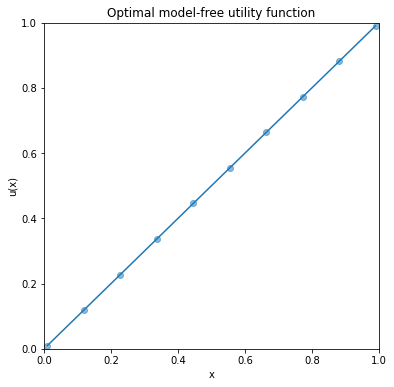

In [15]:
# Create fig
fig, ax = plt.subplots(figsize=(6, 6))

# Set limits
x_min, x_max = 0, 1
y_min, y_max = 0, 1

# Plot estimate
ax.plot(STEPS, su)

# Pimp your plot
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Optimal model-free utility function')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

coord = np.vstack((STEPS, su))
ax.scatter(coord[0], coord[1], alpha=0.5)

plt.show()

## Model-free probability function

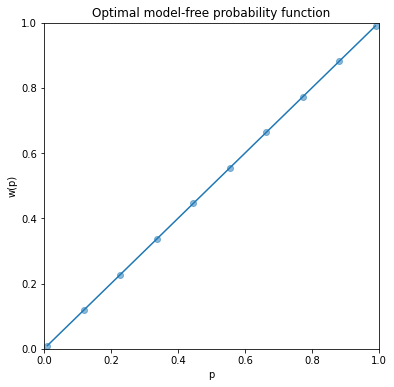

In [16]:
# Create fig
fig, ax = plt.subplots(figsize=(6, 6))

# Set limits
x_min, x_max = 0, 1
y_min, y_max = 0, 1

# Plot estimate
ax.plot(STEPS, sp)

# Pimp your plot
ax.set_xlabel('p')
ax.set_ylabel('w(p)')
ax.set_title('Optimal model-free probability function')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

coord = np.vstack((STEPS, sp))
ax.scatter(coord[0], coord[1], alpha=0.5)

plt.show()

## Softmax function

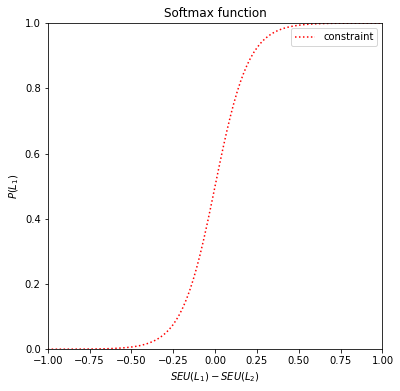

In [17]:
# Softmax function given the difference of value between 2 options
def f(x):
    return expit(x/TAU)

# Create fig
fig, ax = plt.subplots(figsize=(6, 6))

# Set limits
x_min, x_max = -1, 1
y_min, y_max = 0, 1

# Generate x-values
x = np.linspace(x_min, x_max, 100)

# Plot function
ax.plot(x, f(x), ls=':', label='constraint', color="red")

# Pimp your plot
ax.set_xlabel('$SEU(L_1) - SEU(L_2)$')
ax.set_ylabel('$P(L_1)$')
ax.set_title('Softmax function')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.legend()

plt.show()